# Deconvolution with Cell2Location: Deconvolution of VISIUM data


We read our set of CRC 10X VISIUM samples and we run cell2location to perform deconvolution based on the gene expression cell type signatures generated in the previous script. 

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
# os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /pstore/home/valdeola/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-debian-buster-sid-x86_64-3.7.8-64/tmpd3_dcju5/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '6854' (I am process '28173')
/opt/conda/envs/cellpymc/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:16:00.0)


## 1.- Loading Visium data

In [2]:
sp_data_folder = '../Fastq_Merged/'
results_folder = 'Cell2Location/results/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_58covariates_27414cells_13445genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

In [3]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs/',
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique() 
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [4]:
# Read the list of spatial experiments
samples = {'sample_name': ['Count_SN048_A121573_Rep1', 'Count_SN048_A121573_Rep2', 'Count_SN048_A416371_Rep1', 
    'Count_SN048_A416371_Rep2','Count_SN123_A551763_Rep1', 'Count_SN123_A595688_Rep1', 'Count_SN123_A798015_Rep1', 
    'Count_SN124_A551763_Rep2','Count_SN124_A595688_Rep2','Count_SN124_A798015_Rep2',
    'Count_SN124_A938797_Rep2','Count_SN84_A120838_Rep1','Count_SN84_A120838_Rep2', 'SN123_A938797_Rep1']}
sample_data = pd.DataFrame(data=samples)


# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
     slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

In [5]:
adata.var

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-Count_SN048_A121573_Rep1,mean_counts-Count_SN048_A121573_Rep1,log1p_mean_counts-Count_SN048_A121573_Rep1,pct_dropout_by_counts-Count_SN048_A121573_Rep1,total_counts-Count_SN048_A121573_Rep1,log1p_total_counts-Count_SN048_A121573_Rep1,...,log1p_mean_counts-Count_SN84_A120838_Rep2,pct_dropout_by_counts-Count_SN84_A120838_Rep2,total_counts-Count_SN84_A120838_Rep2,log1p_total_counts-Count_SN84_A120838_Rep2,n_cells_by_counts-SN123_A938797_Rep1,mean_counts-SN123_A938797_Rep1,log1p_mean_counts-SN123_A938797_Rep1,pct_dropout_by_counts-SN123_A938797_Rep1,total_counts-SN123_A938797_Rep1,log1p_total_counts-SN123_A938797_Rep1
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000237613,Gene Expression,GRCh38,FAM138A,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000186092,Gene Expression,GRCh38,OR4F5,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000238009,Gene Expression,GRCh38,AL627309.1,False,20,0.009079,0.009038,99.092147,20.0,3.044523,...,0.000954,99.904580,1.0,0.693147,13,0.006579,0.006557,99.389098,14.0,2.708050
ENSG00000239945,Gene Expression,GRCh38,AL627309.3,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000278633,Gene Expression,GRCh38,AC023491.2,False,1,0.000454,0.000454,99.954607,1.0,0.693147,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000276017,Gene Expression,GRCh38,AC007325.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,1,0.000470,0.000470,99.953008,1.0,0.693147


In [6]:
adata.obs

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac
spot_id,,,,,,,,,,,,,
Count_SN048_A121573_Rep1_AAACAAGTATCTCCCA-1,1,50,102,Count_SN048_A121573_Rep1,5341,8.583355,17364.0,9.762212,25.662290,33.920756,43.221608,54.947017,0.028680
Count_SN048_A121573_Rep1_AAACACCAATAACTGC-1,1,59,19,Count_SN048_A121573_Rep1,5674,8.643826,22320.0,10.013283,28.369176,38.342294,47.974910,59.605735,0.083378
Count_SN048_A121573_Rep1_AAACATTTCCCGGATT-1,1,61,97,Count_SN048_A121573_Rep1,3170,8.061802,7669.0,8.945072,24.149172,33.224671,43.160777,57.034815,0.060112
Count_SN048_A121573_Rep1_AAACCCGAACGAAATC-1,1,45,115,Count_SN048_A121573_Rep1,6756,8.818334,27100.0,10.207326,19.712177,27.811808,36.878229,49.793358,0.033727
Count_SN048_A121573_Rep1_AAACCGGGTAGGTACC-1,1,42,28,Count_SN048_A121573_Rep1,4295,8.365440,12265.0,9.414586,23.742356,32.768039,41.956788,54.969425,0.077782
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN123_A938797_Rep1_TTGTTAGCAAATTCGA-1,1,22,42,SN123_A938797_Rep1,2339,7.757906,3494.0,8.159089,12.850601,19.748140,28.992559,46.479679,0.006583
SN123_A938797_Rep1_TTGTTCAGTGTGCTAC-1,1,24,64,SN123_A938797_Rep1,3280,8.095904,6766.0,8.819813,17.188886,25.022170,34.362991,49.600946,0.020396
SN123_A938797_Rep1_TTGTTGTGTGTCAAGA-1,1,31,77,SN123_A938797_Rep1,4068,8.311153,9349.0,9.143131,17.574072,25.414483,34.837951,48.507862,0.028559


Mitochondrial genes are removed for the spatial mapping.

In [7]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

In [8]:
adata.var

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-Count_SN048_A121573_Rep1,mean_counts-Count_SN048_A121573_Rep1,log1p_mean_counts-Count_SN048_A121573_Rep1,pct_dropout_by_counts-Count_SN048_A121573_Rep1,total_counts-Count_SN048_A121573_Rep1,log1p_total_counts-Count_SN048_A121573_Rep1,...,log1p_mean_counts-Count_SN84_A120838_Rep2,pct_dropout_by_counts-Count_SN84_A120838_Rep2,total_counts-Count_SN84_A120838_Rep2,log1p_total_counts-Count_SN84_A120838_Rep2,n_cells_by_counts-SN123_A938797_Rep1,mean_counts-SN123_A938797_Rep1,log1p_mean_counts-SN123_A938797_Rep1,pct_dropout_by_counts-SN123_A938797_Rep1,total_counts-SN123_A938797_Rep1,log1p_total_counts-SN123_A938797_Rep1
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000237613,Gene Expression,GRCh38,FAM138A,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000186092,Gene Expression,GRCh38,OR4F5,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000238009,Gene Expression,GRCh38,AL627309.1,False,20,0.009079,0.009038,99.092147,20.0,3.044523,...,0.000954,99.904580,1.0,0.693147,13,0.006579,0.006557,99.389098,14.0,2.708050
ENSG00000239945,Gene Expression,GRCh38,AL627309.3,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000278633,Gene Expression,GRCh38,AC023491.2,False,1,0.000454,0.000454,99.954607,1.0,0.693147,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000276017,Gene Expression,GRCh38,AC007325.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,1,0.000470,0.000470,99.953008,1.0,0.693147


### 1.1- Look at QC metrics

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


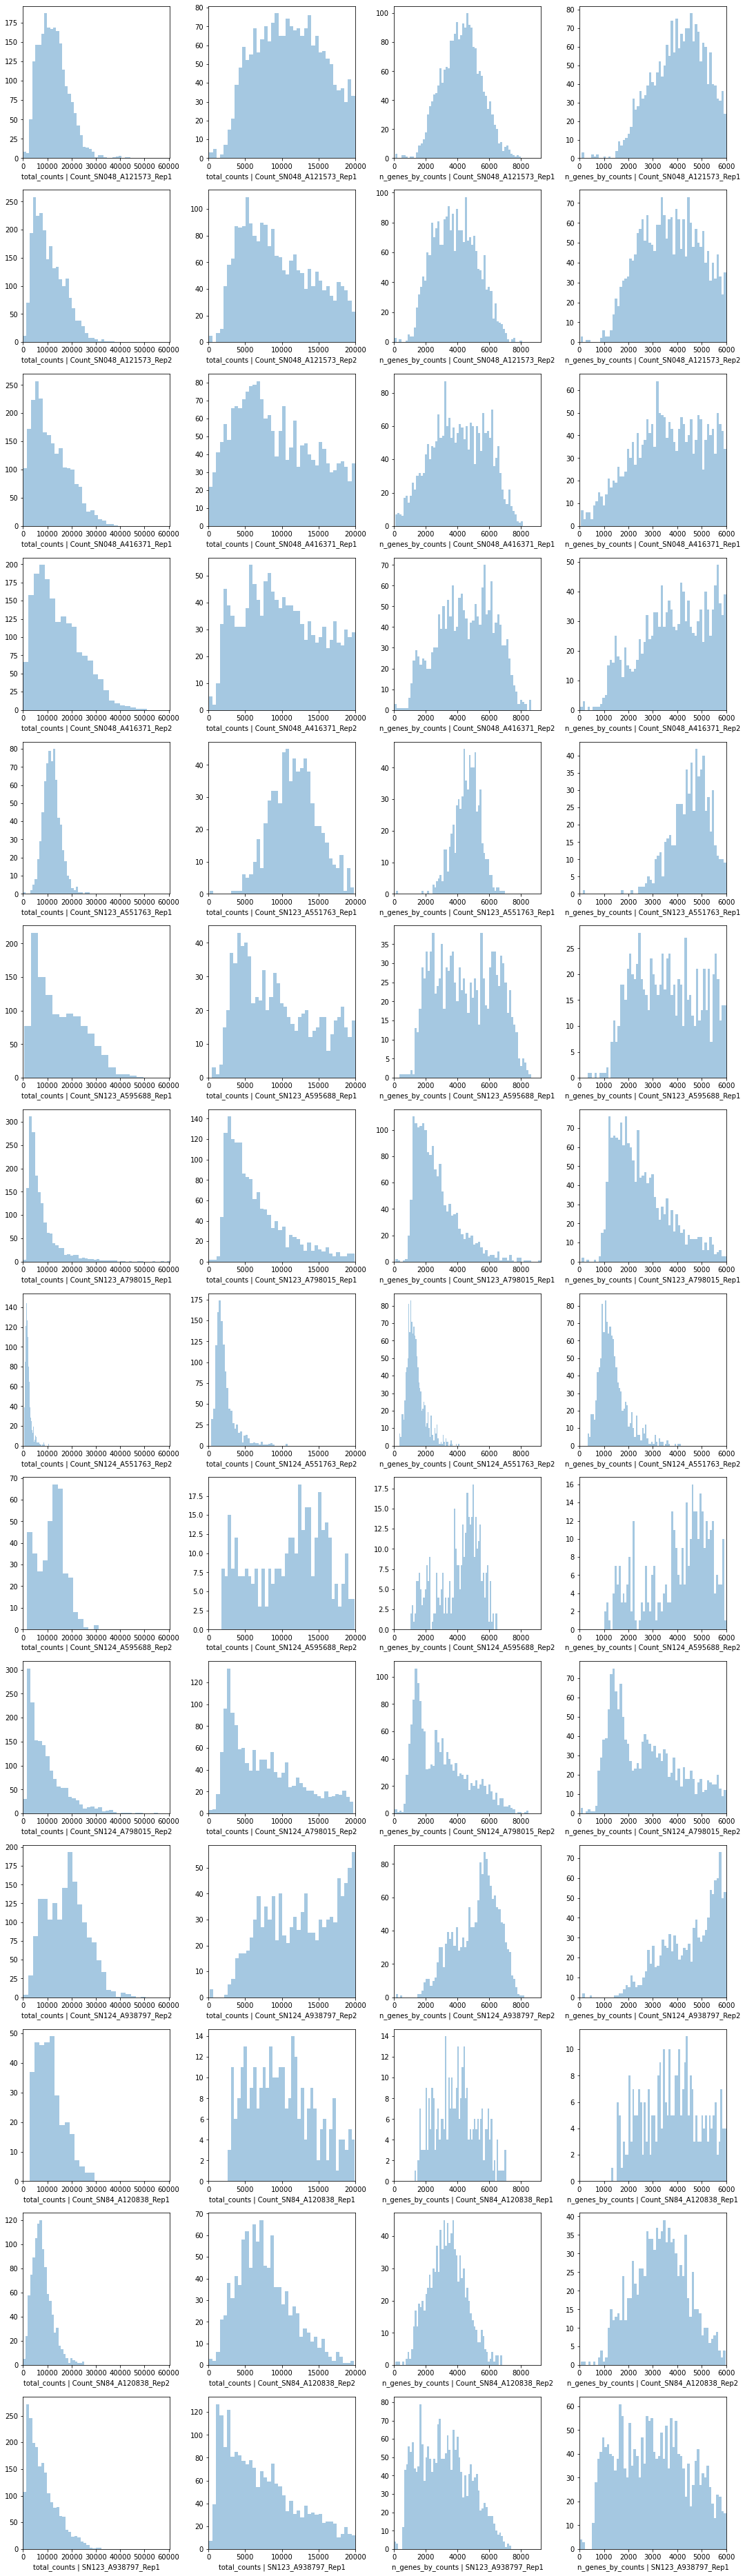

In [9]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    
    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


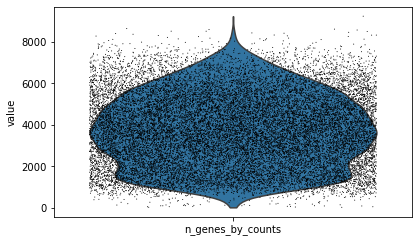

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts'],jitter=0.4)

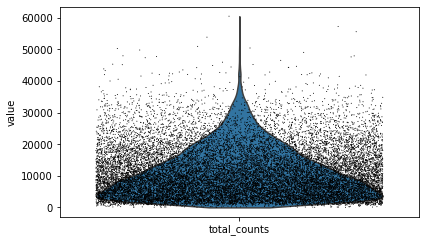

In [11]:
sc.pl.violin(adata, ['total_counts'],jitter=0.4)

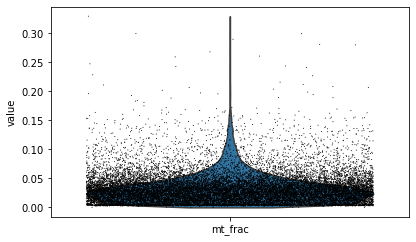

In [12]:
sc.pl.violin(adata, ['mt_frac'],jitter=0.4)

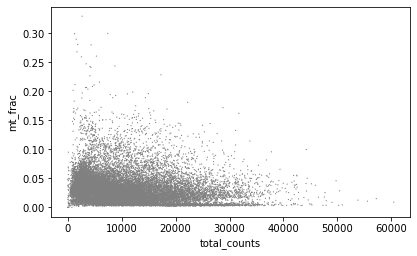

In [13]:
sc.pl.scatter(adata, x='total_counts', y='mt_frac')

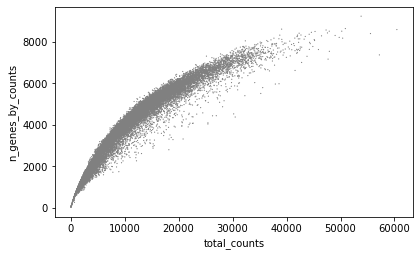

In [14]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Based on these results and the ones presented in the former QC in previous scripts, we decided to make the following filters in accordance with previous analysis: 

In [15]:
adata = adata[(adata.obs.mt_frac < 0.5) & (adata.obs.total_counts > 500) & (adata.obs.total_counts < 45000), :]

In [16]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


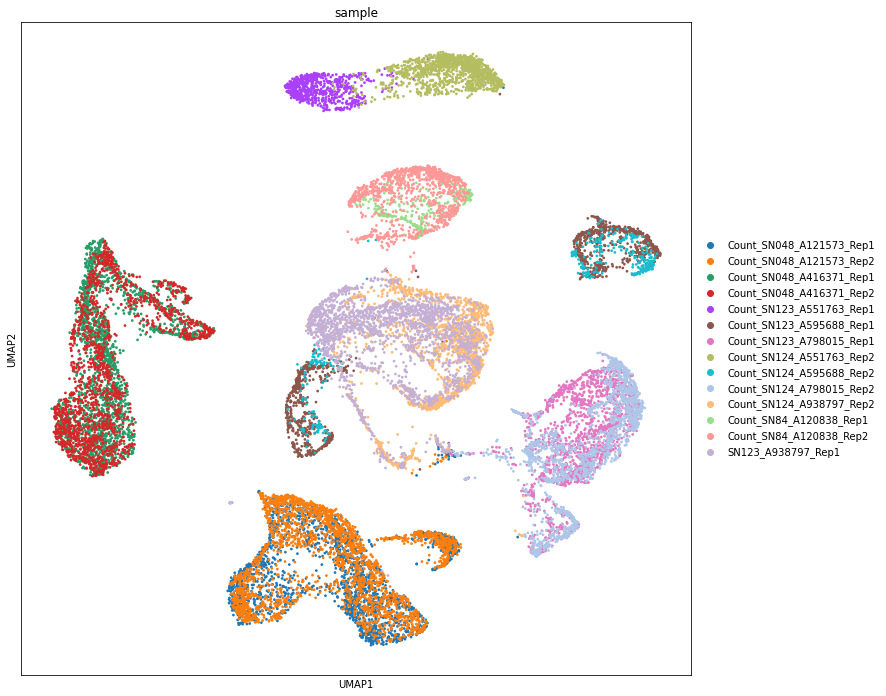

In [17]:
adata_vis_plt = adata_vis.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():

    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)

    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True

# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [12, 12],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

## 2.- Load reference cell type signature from snRNA-seq data and show UMAP of cells

In [18]:
f'{reg_path}sc.h5ad'

'Cell2Location/results/regression_model/RegressionGeneBackgroundCoverageTorch_58covariates_27414cells_13445genes/sc.h5ad'

In [19]:
## scRNAseq reference (raw counts)
adata_scrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [20]:
adata_scrna_raw.obs

,Patient,Class,Sample,Cell_type,Cell_subtype,n_genes
KUL01-B_TGAGCATTCAGCTCTC,KUL01,Border,KUL01-B,Myeloids,Anti-inflammatory,1901
KUL19-N_GTACTCCCAGCCACCA,KUL19,Normal,KUL19-N,Myeloids,Anti-inflammatory,1637
KUL19-N_GTACTTTTCAGTCCCT,KUL19,Normal,KUL19-N,Myeloids,Anti-inflammatory,889
KUL19-N_GTAGTCAAGTTGAGAT,KUL19,Normal,KUL19-N,Myeloids,Anti-inflammatory,1640
KUL19-N_GTCTTCGTCAACCATG,KUL19,Normal,KUL19-N,Myeloids,Anti-inflammatory,1029
...,...,...,...,...,...,...
KUL21-N_CCTCAGTAGCCGATTT,KUL21,Normal,KUL21-N,T cells,gamma delta T cells,1150
KUL21-N_CGATGTAAGGACATTA,KUL21,Normal,KUL21-N,T cells,gamma delta T cells,1044
KUL21-N_CGATGTACAGACAAGC,KUL21,Normal,KUL21-N,T cells,gamma delta T cells,765
KUL21-N_CGCCAAGCATAAAGGT,KUL21,Normal,KUL21-N,T cells,gamma delta T cells,803


In [21]:
# Column name containing cell type annotations
covariate_col_names = 'Cell_subtype'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_scrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_scrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_scrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_scrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [22]:
inf_aver

,Anti-inflammatory,BEST4+ Enterocytes,CD19+CD20+ B,CD4+ T cells,CD8+ T cells,CMS1,CMS2,CMS3,CMS4,Enteric glial cells,...,Stromal 2,Stromal 3,T follicular helper cells,T helper 17 cells,Tip-like ECs,Tuft cells,Unknown,Unspecified Plasma,cDC,gamma delta T cells
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
FO538757.2,8.373544e-02,7.259231e-01,4.977528e-02,4.835632e-02,5.101969e-02,2.350448e-01,1.530508e-01,2.548900e-01,1.818790e-09,9.742739e-02,...,1.599616e-01,1.942382e-01,5.445700e-02,3.134999e-02,1.620270e-01,4.536059e-02,4.578260e-02,1.399872e-03,2.910273e-01,7.278621e-02
AP006222.2,1.021836e-01,1.972247e-01,2.617685e-02,6.322447e-03,2.017959e-02,9.620971e-02,5.498434e-02,8.127420e-02,2.069937e-02,9.867996e-02,...,6.928630e-02,2.144858e-01,1.487157e-02,1.278846e-02,1.416242e-01,2.684130e-09,3.029929e-02,2.686773e-03,8.532730e-02,2.365851e-02
SAMD11,7.903702e-10,2.002296e-09,9.383454e-04,7.287483e-10,1.553261e-04,2.322306e-04,4.133069e-03,2.864218e-03,1.821627e-09,1.019026e-03,...,1.920262e-01,2.757345e-01,8.542223e-10,2.029574e-03,8.225008e-03,2.688213e-09,7.212479e-10,9.632220e-10,3.353495e-03,1.253813e-09
NOC2L,5.352631e-02,5.280371e-01,8.726296e-02,5.181816e-02,6.050757e-02,4.258868e-01,2.520528e-01,3.610118e-01,2.225596e-01,5.947371e-02,...,1.816426e-01,2.065549e-01,3.342537e-02,9.815622e-02,1.790540e-01,2.701680e-09,3.490650e-02,7.831617e-04,2.846541e-01,4.153477e-02
PLEKHN1,1.446539e-03,2.004049e-09,4.749096e-05,1.630045e-02,7.754877e-03,1.147966e-01,5.617121e-02,9.800107e-02,3.589453e-02,9.939458e-10,...,1.274231e-02,9.062206e-04,3.627884e-03,2.528367e-02,9.719074e-03,2.685113e-09,2.094679e-02,9.659375e-10,1.659922e-02,1.850122e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,1.701106e-02,8.449733e-02,3.995817e-02,1.604997e-02,7.390649e-03,2.578177e-02,2.029105e-02,7.981339e-02,1.823935e-09,3.447012e-02,...,9.541140e-03,4.133856e-02,5.624516e-02,2.668011e-03,1.897252e-02,2.734200e-09,4.253875e-03,3.539254e-03,2.669836e-02,2.185931e-02
AC007325.4,2.559112e-02,2.002273e-09,5.822370e-04,5.440143e-03,6.044240e-03,3.477060e-02,9.724092e-02,4.574324e-02,1.814217e-09,1.208696e-02,...,1.259336e-02,8.891227e-02,6.158666e-03,1.099673e-02,4.282165e-02,2.693510e-09,7.171496e-03,9.619386e-10,1.813124e-02,2.549825e-02
AC004556.1,8.230759e-03,7.109179e-02,5.558951e-03,1.740673e-03,1.668098e-03,1.813351e-02,1.248554e-01,9.318242e-02,8.254058e-03,2.186229e-03,...,1.537159e-03,4.868655e-03,7.153456e-03,3.354483e-03,1.804083e-03,1.967217e-02,3.807033e-03,1.106632e-03,4.210907e-02,3.498293e-03


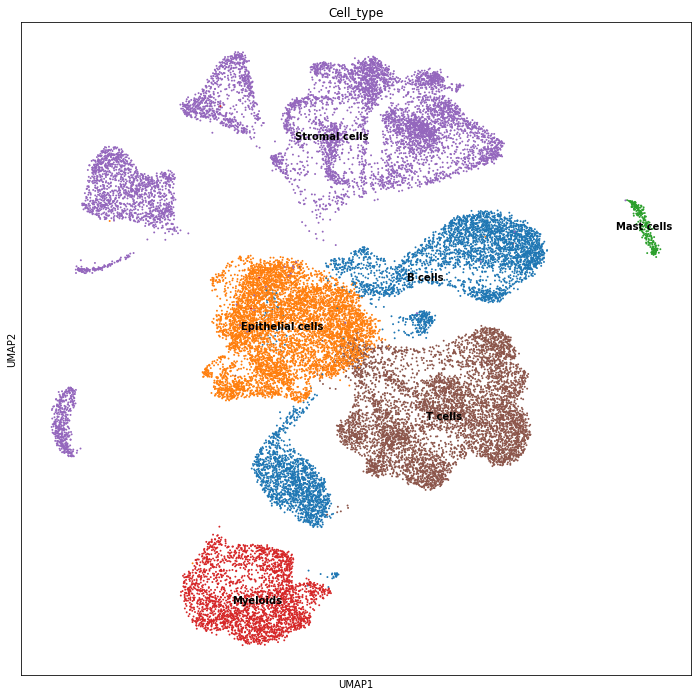

In [23]:
with mpl.rc_context({'figure.figsize': [12, 12],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_scrna_raw, color=['Cell_type'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

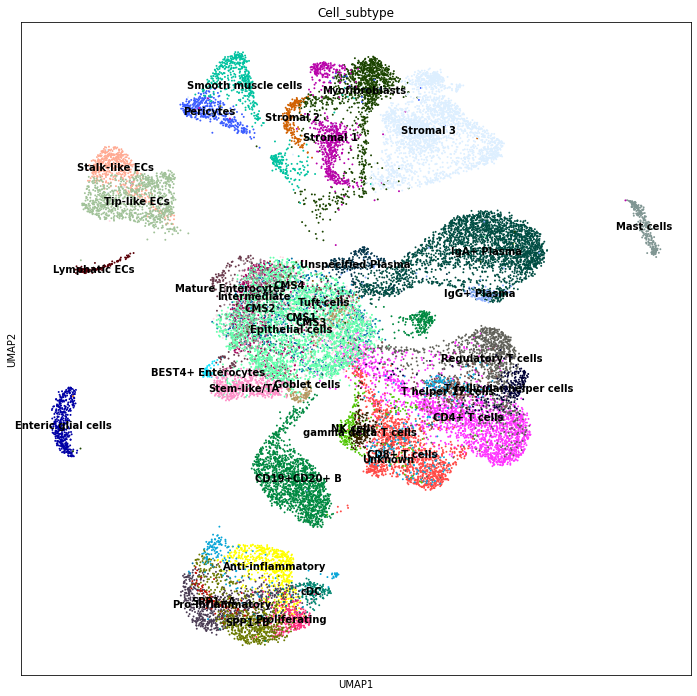

In [24]:
with mpl.rc_context({'figure.figsize': [12, 12],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_scrna_raw, color=['Cell_subtype'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

### 2.1- Gene Selection

In [25]:
# selecting most informative genes based on specificity
selection_specificity = 0.20

# normalise expression signatures:
cell_state_df_norm = (inf_aver.T / inf_aver.sum(1)).T
# apply cut off:
cell_state_df_norm = (cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
cell_state_df_norm.sum(0), (cell_state_df_norm.sum(1) > 0).sum(0)

(Anti-inflammatory              33
 BEST4+ Enterocytes            379
 CD19+CD20+ B                   55
 CD4+ T cells                   10
 CD8+ T cells                   33
 CMS1                          186
 CMS2                          115
 CMS3                          188
 CMS4                           23
 Enteric glial cells           178
 Epithelial cells              137
 Goblet cells                  161
 IgA+ Plasma                   209
 IgG+ Plasma                   125
 Intermediate                    3
 Lymphatic ECs                 202
 Mast cells                     82
 Mature Enterocytes            181
 Myofibroblasts                317
 NK cells                       35
 Pericytes                     206
 Pro-inflammatory               45
 Proliferating                 284
 Regulatory T cells             36
 SPP1+A                        104
 SPP1+B                         81
 Smooth muscle cells           215
 Stalk-like ECs                254
 Stem-like/TA       

In [26]:
del adata_scrna_raw, slides
gc.collect()

54229

In [27]:
adata_vis.var_names = adata_vis.var["SYMBOL"]
adata_vis.var.drop(columns='SYMBOL', inplace=True)

In [28]:
adata_vis.var

,feature_types,genome,mt,n_cells_by_counts-Count_SN048_A121573_Rep1,mean_counts-Count_SN048_A121573_Rep1,log1p_mean_counts-Count_SN048_A121573_Rep1,pct_dropout_by_counts-Count_SN048_A121573_Rep1,total_counts-Count_SN048_A121573_Rep1,log1p_total_counts-Count_SN048_A121573_Rep1,n_cells_by_counts-Count_SN048_A121573_Rep2,...,log1p_mean_counts-Count_SN84_A120838_Rep2,pct_dropout_by_counts-Count_SN84_A120838_Rep2,total_counts-Count_SN84_A120838_Rep2,log1p_total_counts-Count_SN84_A120838_Rep2,n_cells_by_counts-SN123_A938797_Rep1,mean_counts-SN123_A938797_Rep1,log1p_mean_counts-SN123_A938797_Rep1,pct_dropout_by_counts-SN123_A938797_Rep1,total_counts-SN123_A938797_Rep1,log1p_total_counts-SN123_A938797_Rep1
SYMBOL,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,0,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
FAM138A,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,0,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
OR4F5,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,0,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
AL627309.1,Gene Expression,GRCh38,False,20,0.009079,0.009038,99.092147,20.0,3.044523,15,...,0.000954,99.904580,1.0,0.693147,13,0.006579,0.006557,99.389098,14.0,2.708050
AL627309.3,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,0,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,0,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
AC023491.2,Gene Expression,GRCh38,False,1,0.000454,0.000454,99.954607,1.0,0.693147,1,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
AC007325.1,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,0,...,0.000000,100.000000,0.0,0.000000,1,0.000470,0.000470,99.953008,1.0,0.693147


In [29]:
inf_aver.index = inf_aver.index.rename('SYMBOL')

In [30]:
inf_aver

,Anti-inflammatory,BEST4+ Enterocytes,CD19+CD20+ B,CD4+ T cells,CD8+ T cells,CMS1,CMS2,CMS3,CMS4,Enteric glial cells,...,Stromal 2,Stromal 3,T follicular helper cells,T helper 17 cells,Tip-like ECs,Tuft cells,Unknown,Unspecified Plasma,cDC,gamma delta T cells
SYMBOL,,,,,,,,,,,,,,,,,,,,,
FO538757.2,8.373544e-02,7.259231e-01,4.977528e-02,4.835632e-02,5.101969e-02,2.350448e-01,1.530508e-01,2.548900e-01,1.818790e-09,9.742739e-02,...,1.599616e-01,1.942382e-01,5.445700e-02,3.134999e-02,1.620270e-01,4.536059e-02,4.578260e-02,1.399872e-03,2.910273e-01,7.278621e-02
AP006222.2,1.021836e-01,1.972247e-01,2.617685e-02,6.322447e-03,2.017959e-02,9.620971e-02,5.498434e-02,8.127420e-02,2.069937e-02,9.867996e-02,...,6.928630e-02,2.144858e-01,1.487157e-02,1.278846e-02,1.416242e-01,2.684130e-09,3.029929e-02,2.686773e-03,8.532730e-02,2.365851e-02
SAMD11,7.903702e-10,2.002296e-09,9.383454e-04,7.287483e-10,1.553261e-04,2.322306e-04,4.133069e-03,2.864218e-03,1.821627e-09,1.019026e-03,...,1.920262e-01,2.757345e-01,8.542223e-10,2.029574e-03,8.225008e-03,2.688213e-09,7.212479e-10,9.632220e-10,3.353495e-03,1.253813e-09
NOC2L,5.352631e-02,5.280371e-01,8.726296e-02,5.181816e-02,6.050757e-02,4.258868e-01,2.520528e-01,3.610118e-01,2.225596e-01,5.947371e-02,...,1.816426e-01,2.065549e-01,3.342537e-02,9.815622e-02,1.790540e-01,2.701680e-09,3.490650e-02,7.831617e-04,2.846541e-01,4.153477e-02
PLEKHN1,1.446539e-03,2.004049e-09,4.749096e-05,1.630045e-02,7.754877e-03,1.147966e-01,5.617121e-02,9.800107e-02,3.589453e-02,9.939458e-10,...,1.274231e-02,9.062206e-04,3.627884e-03,2.528367e-02,9.719074e-03,2.685113e-09,2.094679e-02,9.659375e-10,1.659922e-02,1.850122e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,1.701106e-02,8.449733e-02,3.995817e-02,1.604997e-02,7.390649e-03,2.578177e-02,2.029105e-02,7.981339e-02,1.823935e-09,3.447012e-02,...,9.541140e-03,4.133856e-02,5.624516e-02,2.668011e-03,1.897252e-02,2.734200e-09,4.253875e-03,3.539254e-03,2.669836e-02,2.185931e-02
AC007325.4,2.559112e-02,2.002273e-09,5.822370e-04,5.440143e-03,6.044240e-03,3.477060e-02,9.724092e-02,4.574324e-02,1.814217e-09,1.208696e-02,...,1.259336e-02,8.891227e-02,6.158666e-03,1.099673e-02,4.282165e-02,2.693510e-09,7.171496e-03,9.619386e-10,1.813124e-02,2.549825e-02
AC004556.1,8.230759e-03,7.109179e-02,5.558951e-03,1.740673e-03,1.668098e-03,1.813351e-02,1.248554e-01,9.318242e-02,8.254058e-03,2.186229e-03,...,1.537159e-03,4.868655e-03,7.153456e-03,3.354483e-03,1.804083e-03,1.967217e-02,3.807033e-03,1.106632e-03,4.210907e-02,3.498293e-03


## 3.- Deconvolution

In [31]:
sc.settings.set_figure_params(dpi = 100, color_map = 'viridis', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(

      # Single cell reference signatures as pd.DataFrame
      # (could also be data as anndata object for estimating signatures
      #  as cluster average expression - `sc_data=adata_snrna_raw`)
      sc_data=inf_aver,
      # Spatial data as anndata object
      sp_data=adata_vis,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "Cell_subtype",
                         # select marker genes of cell types by specificity of their expression signatures
                         'selection': "cluster_specificity",
                         # specificity cutoff (1 = max, 0 = min)
                         'selection_specificity': 0.20
                        },

      train_args={'use_raw': True, # By default uses raw slots in both of the input datasets.
                  'n_iter': 40000, # Increase the number of iterations if needed (see QC below)

                  # Whe analysing the data that contains multiple experiments,
                  # cell2location automatically enters the mode which pools information across experiments
                  'sample_name_col': 'sample'}, # Column in sp_data.obs with experiment ID (see above)


      export_args={'path': results_folder, # path where to save results
                   'run_name_suffix': '' # optinal suffix to modify the name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located groups

                    'cell_number_prior': {
                        # - N - the expected number of cells per location:
                        'cells_per_spot': 8,
                        # - A - the expected number of cell types per location:
                        'factors_per_spot': 9,
                        # - Y - the expected number of co-located cell type groups per location
                        'combs_per_spot': 5
                    },

                     # Prior beliefs on the sensitivity of spatial technology:
                    'gene_level_prior':{
                        # Prior on the mean
                        'mean': 1/2,
                        # Prior on standard deviation,
                        # a good choice of this value should be at least 2 times lower that the mean
                        'sd': 1/4
                    }
      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.04 min
### Analysis name: LocationModelLinearDependentWMultiExperiment_14experiments_40clusters_20654locations_4306genes
### Training model ###


Finished [100%]: Average Loss = 4.1981e+07


Finished [100%]: Average Loss = 4.1981e+07



### Sampling posterior ### - time 84.49 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
### Done ### - time 110.78 min


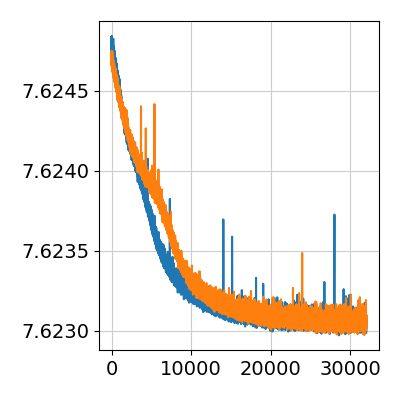

In [32]:
from IPython.display import Image
Image(filename=results_folder +r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

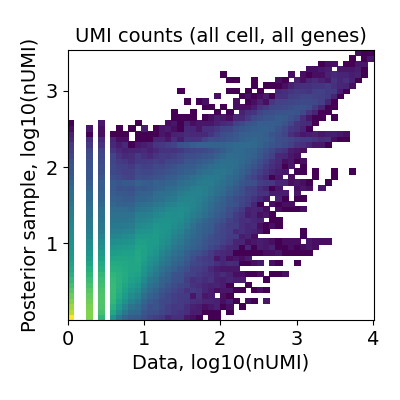

In [33]:
Image(filename=results_folder +r['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

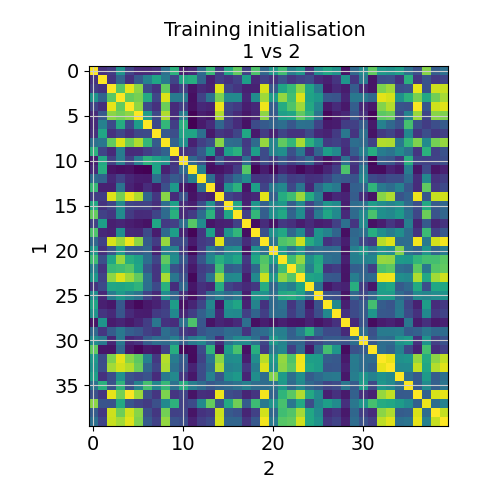

In [34]:
Image(filename=results_folder +r['run_name']+'/plots/evaluate_stability.png',
      width=400)

In [35]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.8 | packaged by conda-forge | (default, Nov 17 2020, 23:45:15) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.19.0
IPython.core.release 7.19.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.19.0
pygments 2.7.2
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.0
jupyter_core.version 4.7.0
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.8
scanpy 1.